In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split

from model.autoencoder import Autoencoder

/Users/elisawolia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
EPOCHS = 20
BATCH_SIZE = 64
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

torch.seed = 42

print(torch.__version__)
print(DEVICE)

2.1.2
cpu


In [3]:
Transform = transforms.Compose([
    transforms.Resize((32, 48)),
    transforms.CenterCrop((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

dataset = ImageFolder(root='./dataset/train', transform=Transform)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

In [6]:
def train(train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(validation_loader, validation_losses):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [8]:
train_losses = []
validation_losses = []

for epoch in range(1, EPOCHS+1):
    train(train_loader, optimizer, epoch, train_losses)
    test(validation_loader, validation_losses)

Epoch:1 [1856/8000 (23%)]	Loss: 0.048233930
Epoch:1 [3776/8000 (47%)]	Loss: 0.015543048
Epoch:1 [5696/8000 (71%)]	Loss: 0.008248938
Epoch:1 [7616/8000 (95%)]	Loss: 0.004963969
Validation set: Average loss: 0.004757552

Epoch:2 [1856/8000 (23%)]	Loss: 0.002810568
Epoch:2 [3776/8000 (47%)]	Loss: 0.001750023
Epoch:2 [5696/8000 (71%)]	Loss: 0.001098937
Epoch:2 [7616/8000 (95%)]	Loss: 0.000787466
Validation set: Average loss: 0.000745154

Epoch:3 [1856/8000 (23%)]	Loss: 0.000580575
Epoch:3 [3776/8000 (47%)]	Loss: 0.000446914
Epoch:3 [5696/8000 (71%)]	Loss: 0.000347877
Epoch:3 [7616/8000 (95%)]	Loss: 0.000298706
Validation set: Average loss: 0.000287605

Epoch:4 [1856/8000 (23%)]	Loss: 0.000270766
Epoch:4 [3776/8000 (47%)]	Loss: 0.000214984
Epoch:4 [5696/8000 (71%)]	Loss: 0.000178760
Epoch:4 [7616/8000 (95%)]	Loss: 0.000180852
Validation set: Average loss: 0.000177550

Epoch:5 [1856/8000 (23%)]	Loss: 0.000155411
Epoch:5 [3776/8000 (47%)]	Loss: 0.000151463
Epoch:5 [5696/8000 (71%)]	Loss: 0.00

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((32, 48)),
    transforms.CenterCrop((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

proliv_dataset = ImageFolder(root='./dataset/proliv/', transform=test_transform)
proliv_loader = DataLoader(proliv_dataset, batch_size=2, shuffle=False)

In [10]:
model.eval()
proliv = []

with torch.no_grad():
    for images, _ in proliv_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, images)
        proliv.append(loss.item())

In [11]:
proliv_min = min(proliv)
print(proliv_min)

3.717735307873227e-05


In [12]:
test_dataset = ImageFolder(root='./dataset/test/imgs/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print(len(test_dataset))

3794


In [13]:
model.eval()

true_labels = []
predicted_labels = []
test_losses = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, images)
        true_labels.append(label)
        test_losses.append(loss.item())
        predicted_labels.append(loss.item() > proliv_min)

Accuracy per class:  [0.92796726 0.99224806]
Precision per class:  [0.99970606 0.32653061]
Recall per class:  [0.92796726 0.99224806]
F1 per class:  [0.96250177 0.49136276]


<Axes: >

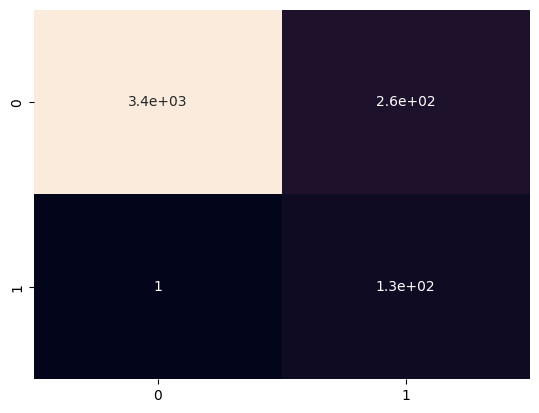

In [14]:
confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

tn, fp, fn, tp = confusion.ravel()
sns.heatmap(confusion, cbar = False, annot = True)

In [15]:
tpr = tp / (tp + fn)
tpr

0.9922480620155039

In [16]:
tnr = tn / (tn + fp)
tnr

0.9279672578444748

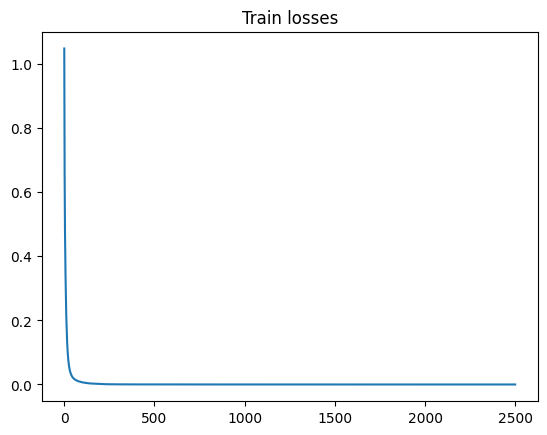

In [17]:
plt.title('Train losses')
plt.plot(train_losses)